# P2: Advanced Lane Finding
## Import Packages

In [2]:
# importing packages necessary 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

## Process

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Supporting Functions

In [107]:
def calibrate(calibration_dir, nx, ny):
    """ Calibrates a camera using a directory of calibration images
    Requires the number of x- and y- inner corners within the calibration checkerboard
    Returns the associated pairs of object point and image point arrays
    """
    # set up empty arrays to store calibration values
    objpoints, imgpoints = [], [] 
    
    # populate the objpoints array
    # we will re-use this as a constant across the entire directory of calibration images
    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
        
    # calibrate using each image in our calibration folder
    cal_paths = os.listdir(calibration_dir)
    for cal_path in cal_paths:
        cal = mpimg.imread(calibration_dir+cal_path)

        # detect the corners from within the image
        gray = cv2.cvtColor(cal, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret == True:
            # append the corner locations to our array
            imgpoints.append(corners)
            objpoints.append(objp)
            
    return objpoints, imgpoints

def undistort(img):
    """ Used camera calibration to undistort an image
    Returns the undistorted image
    """
    # grab the calibration arrays using the source directory
    # we expect the checkerboard to have 9 x- and 6 y- inner corners
    objpoints, imgpoints = calibrate('camera_cal/', 9, 6)

    # obtain the calibration coefficents using the point arrays
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:], None, None)

    # undistort the image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    return undist

def b_threshold(img):
    """ Uses B values from the LAB color space to detect yellow lane lines
    Returns a thresholded version of the input image
    """
    # convert the image to LAB color space and grab the B channel
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    b_channel = lab[:,:,2]

    # apply the B channel threshold
    b_thresh_min, b_thresh_max = 150, 255
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    return b_binary

def l_threshold(img):
    """ Uses L values from the HLS color space to detect white lane lines
    Returns a thresholded version of the input image
    """
    # convert the image to HLS color space and grab the L channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]

    # apply the L channel threshold
    l_thresh_min, l_thresh_max = 200, 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1
    
    return l_binary

def sx_threshold(img):
    """ Uses Sobel X gradient values to identify lane edges
    Returns a thresholded version of the input image
    """
    # grab the sobel X gradient from a grayscaled version of the image 
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    
    # take the absolute value and scale it to fit the image's 256 range
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # apply the X gradient threshold
    thresh_min, thresh_max = 30, 100
    sx_binary = np.zeros_like(scaled_sobel)
    sx_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return sx_binary

def threshold(img):
    """ Uses Sobel X coefficient, LAB B-values, and HLS L-values to identify lanes in an image
    Returns a binary threshold version of the input image 
    """
    # generate three different thresholds
    b_img = b_threshold(undist)
    l_img = l_threshold(undist)
    sx_img = sx_threshold(undist)

    # combine the binary thresholds
    combined_binary = np.zeros_like(b_img)
    combined_binary[(b_img == 1) | (l_img == 1) | (sx_img == 1)] = 1
    
    return combined_binary

def warp(img):
    """ Warps an image so that it centers the lane and pr
    """
    size = (undist.shape[1], undist.shape[0])

    # define source and destination coordinates for the unwarped image
    # source: approximate expected coordinates of road positioned in camera view
    src = np.float32(
        [[(size[0]*.5-40), size[1]*.63],
        [size[0]*.20, size[1]],
        [size[0]*.90, size[1]],
        [(size[0]*.5+40), size[1]*.63]])
    # destination: positioned such that the left lane stretches top-to-bottom through the middle
    # of the left half of the screen, and the right lane through the middle of the right half
    dst = np.float32(
        [[size[0]*.25, 0],
        [size[0]*.25, size[1]],
        [size[0]*.75, size[1]],
        [size[0]*.75, 0]])

    # display the source range on top of the undistorted image
    src_overlay = undist.copy()
    cv2.polylines(src_overlay, np.int_([src]), True, (0,255, 0), 8)

    # get the transformation matrix from the source/destination and use it to warp the image
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, size, flags=cv2.INTER_LINEAR)

## Display Test Images

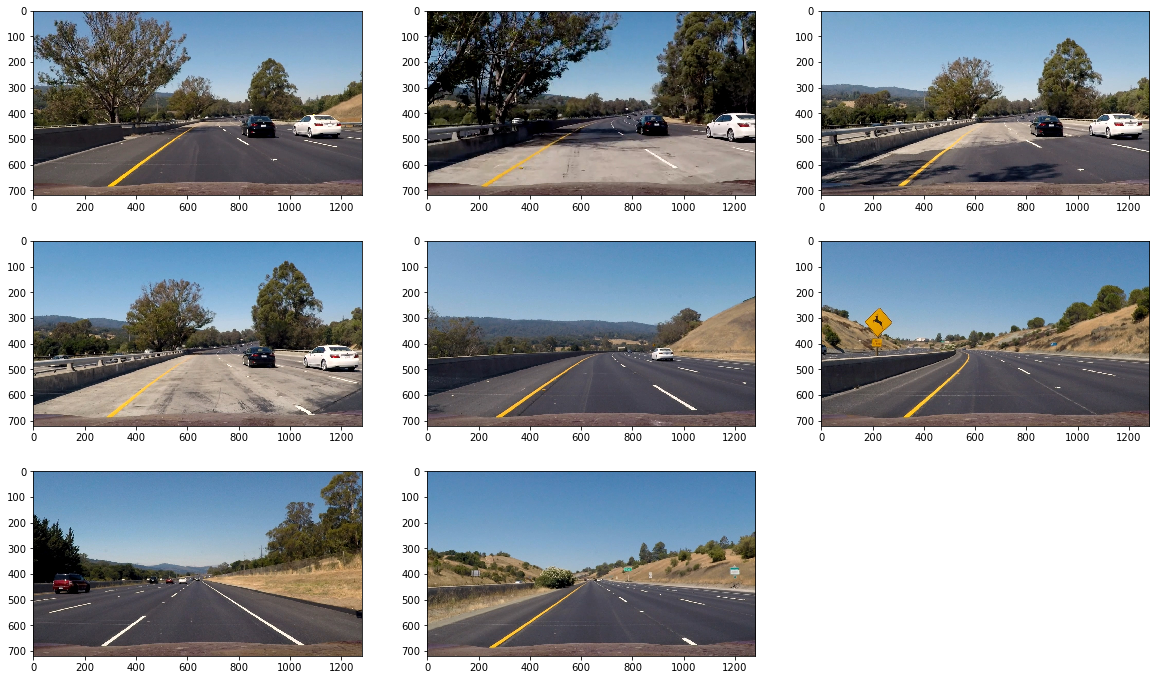

In [22]:
# display the entire directory of test images for reference
img_paths = os.listdir('test_images/')
plt.figure(figsize=(20,12))
cols, idx = 3, 0
for img_path in img_paths:
    img = mpimg.imread('test_images/'+img_path)
    plt.subplot(len(img_paths)/cols + 1, cols, idx+1)
    plt.imshow(img)
    idx += 1

## Compute Calibration and Undistort Image

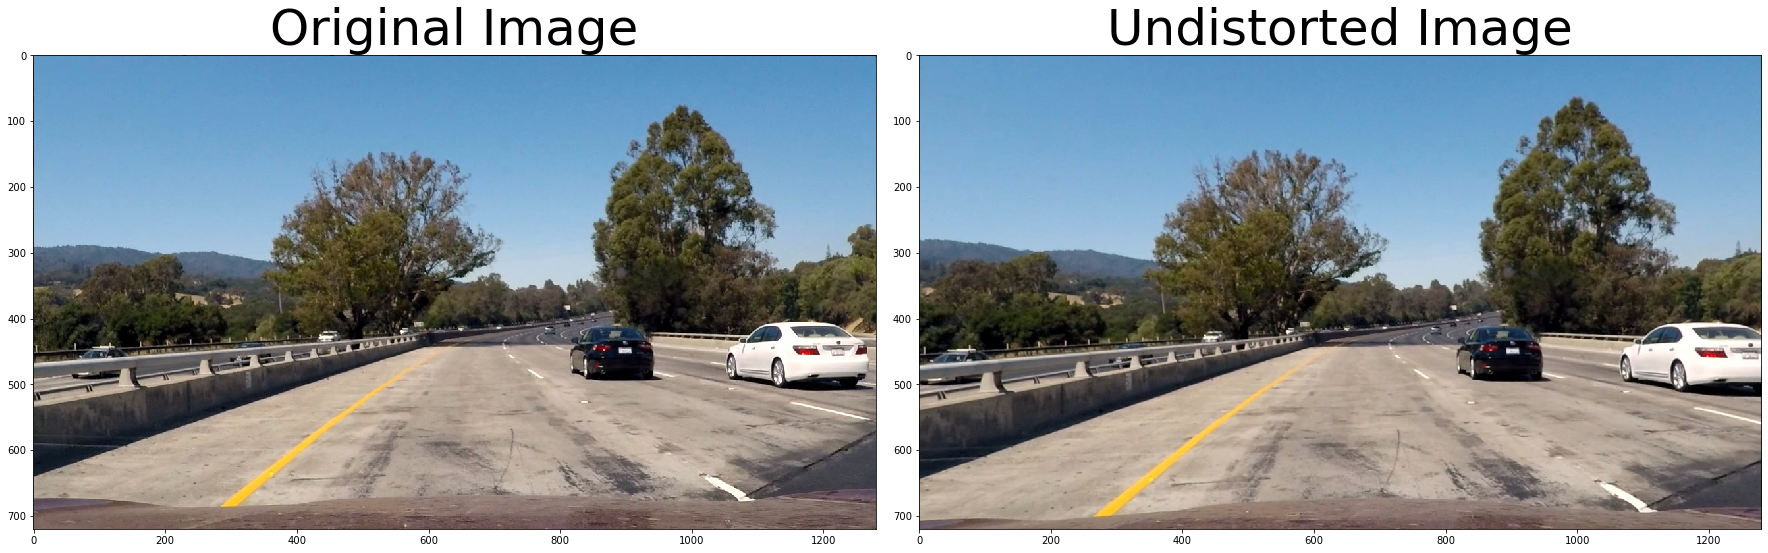

In [53]:
# identify the image to undistort
img = mpimg.imread('test_images/test1.jpg')

# grab the calibration arrays using the source directory
# we expect the checkerboard to have 9 x- and 6 y- inner corners
objpoints, imgpoints = calibrate('camera_cal/', 9, 6)

# obtain the calibration coefficents using the point arrays
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:], None, None)

# undistort the image
undist = cv2.undistort(img, mtx, dist, None, mtx)

# display the undistorted image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Color and Gradient Thresholding

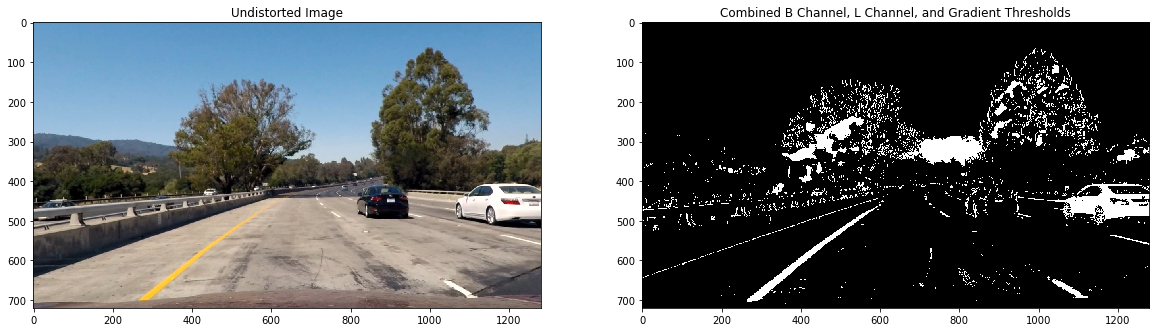

In [113]:
# grab the undistorted image
img = mpimg.imread('test_images/test1.jpg')
undist = undistort(img)

# generate thresholds to detect lane edges (using Sobel X coefficient),
# yellow lanes (LAB B values) and white lanes (HLS L values)
b_img = b_threshold(undist)
l_img = l_threshold(undist)
sx_img = sx_threshold(undist)

# combine the binary thresholds
combined_binary = np.zeros_like(b_img)
combined_binary[(b_img == 1) | (l_img == 1) | (sx_img == 1)] = 1

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Undistorted Image')
ax1.imshow(undist)
ax2.set_title('Combined B Channel, L Channel, and Gradient Thresholds')
ax2.imshow(combined_binary, cmap='gray')

## Apply Perspective Transform

Text(0.5, 1.0, 'Warped Image with Destination Marked')

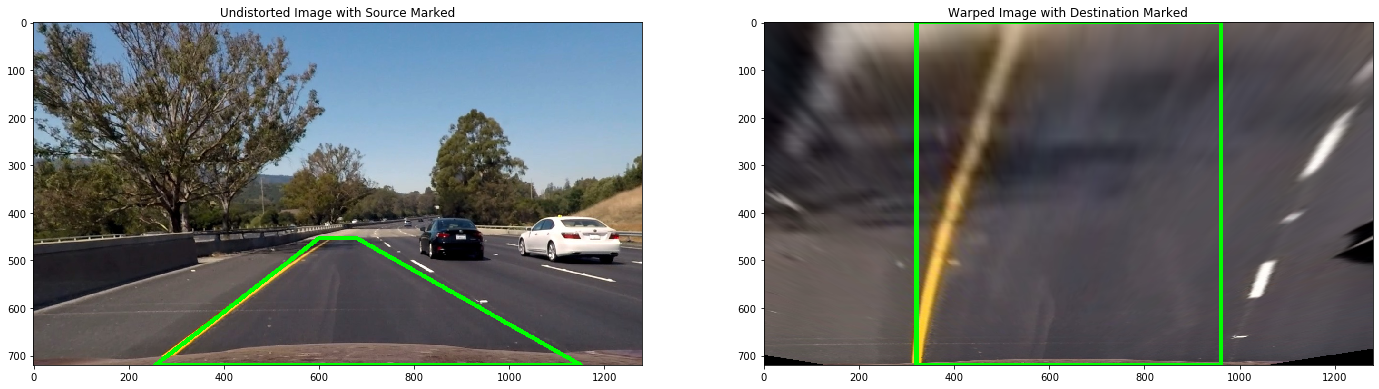

In [190]:
# grab the undistorted image
img = mpimg.imread('test_images/test6.jpg')
undist = undistort(img)
size = (undist.shape[1], undist.shape[0])

# define source and destination coordinates for the unwarped image
# source: approximate expected coordinates of road positioned in camera view
src = np.float32(
    [[(size[0]*.5-40), size[1]*.63],
    [size[0]*.20, size[1]],
    [size[0]*.90, size[1]],
    [(size[0]*.5+40), size[1]*.63]])
# destination: positioned such that the left lane stretches top-to-bottom through the middle
# of the left half of the screen, and the right lane through the middle of the right half
dst = np.float32(
    [[size[0]*.25, 0],
    [size[0]*.25, size[1]],
    [size[0]*.75, size[1]],
    [size[0]*.75, 0]])

# display the source range on top of the undistorted image
src_overlay = undist.copy()
cv2.polylines(src_overlay, np.int_([src]), True, (0,255, 0), 8)

# get the transformation matrix from the source/destination and use it to warp the image
M = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(undist, M, size, flags=cv2.INTER_LINEAR)
cv2.polylines(warped, np.int_([dst]), True, (0,255, 0), 8)

# display the warped image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(src_overlay)
ax1.set_title('Undistorted Image with Source Marked')
ax2.imshow(warped)
ax2.set_title('Warped Image with Destination Marked')